# Avaliação - Parte Prática

PSI3471 - Fundamentos de Sistemas Eletrônicos Inteligentes (2024)

Sophia Celine Rafael Alves Pereira 

NºUSP 11803994

In [1]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix


/home/soph/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


## Manipulação dos dados

In [1]:
!wget https://psi3471.github.io/www/data.zip

--2024-05-10 16:39:01--  https://psi3471.github.io/www/data.zip
Resolving psi3471.github.io (psi3471.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to psi3471.github.io (psi3471.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8850 (8,6K) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   8,64K  --.-KB/s    in 0,002s  

2024-05-10 16:39:02 (3,68 MB/s) - ‘data.zip’ saved [8850/8850]



In [2]:
!unzip data.zip

Archive:  data.zip
  inflating: data_test.csv           
  inflating: data_train.csv          


In [2]:
data_train = pd.read_csv("data_train.csv").drop(columns=["Unnamed: 0"])
data_test = pd.read_csv("data_test.csv").drop(columns=["Unnamed: 0"])

In [3]:
data_train.shape

(800, 14)

In [4]:
data_test.shape

(225, 14)

In [5]:
data_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,52.0,1.0,0.0,125.0,212.0,0.0,1.0,168.0,0.0,1.0,2.0,2.0,3.0,0.0
1,53.0,1.0,0.0,140.0,203.0,1.0,0.0,155.0,1.0,3.1,0.0,0.0,3.0,0.0
2,70.0,1.0,0.0,145.0,174.0,0.0,1.0,125.0,1.0,2.6,0.0,0.0,3.0,0.0
3,61.0,1.0,0.0,148.0,203.0,0.0,1.0,161.0,0.0,0.0,2.0,1.0,3.0,0.0
4,62.0,0.0,0.0,138.0,294.0,1.0,1.0,106.0,0.0,1.9,1.0,3.0,2.0,0.0


In [6]:
data_test.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,67.0,1.0,0.0,120.0,229.0,0.0,0.0,129.0,1.0,2.6,1.0,2.0,3.0,0.0
1,63.0,1.0,3.0,145.0,233.0,1.0,0.0,150.0,0.0,2.3,0.0,0.0,1.0,1.0
2,63.0,0.0,0.0,124.0,197.0,0.0,1.0,136.0,1.0,0.0,1.0,0.0,2.0,0.0
3,52.0,1.0,0.0,112.0,230.0,0.0,1.0,160.0,0.0,0.0,2.0,1.0,2.0,0.0
4,58.0,0.0,0.0,130.0,197.0,0.0,1.0,131.0,0.0,0.6,1.0,0.0,2.0,1.0


In [8]:
X_train, y_train = data_train.iloc[:, :-1].values, data_train.iloc[:, -1].values
X_test, y_test = data_test.iloc[:, :-1].values, data_test.iloc[:, -1].values

In [9]:
# Normalização
X_train = (X_train - X_train.mean(axis=0)) / X_train.std(axis=0)
X_test = (X_test - X_train.mean(axis=0)) / X_train.std(axis=0)

In [10]:
# Hiperparâmetros
# Passo de adaptação (learning rate)
eta = 0.001
# Tamanho do mini-batch
Nb = 80
# Número de épocas
Ne = 300
# Taxa de droput
p = 0.3

In [11]:
class ExamesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).view(-1, 1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

np.random.seed(20)
torch.manual_seed(20)
torch.cuda.manual_seed(20)

train_dataset = ExamesDataset(X_train, y_train)
test_dataset = ExamesDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=Nb, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=True)

## Rede neural implementada

In [27]:
class Model(nn.Module):

    def __init__(self):
        super().__init__()
        
        self.model = nn.Sequential(
            nn.Linear(13, 26),
            nn.ReLU(),
            nn.Dropout(p),
            
            nn.Linear(26, 39),
            nn.ReLU(),

            nn.Linear(39, 13),
            nn.ReLU(),
            
            nn.Linear(13, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        output = self.model(x)
        return output

In [45]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Model().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=eta) 
loss_function = nn.BCELoss()

### Treinamento

In [46]:
train_losses = []
val_losses = []
accuracies = []

for epoch in range(Ne):
    model.train()
    train_loss = 0.0
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    model.eval()
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            predictions = (outputs >= 0.5).float()
            cm_train = confusion_matrix(targets.cpu(), predictions.cpu())
            accuracy = accuracy_score(targets.cpu(), predictions.cpu())
            accuracies.append(accuracy)
        valid_loss = loss_function(outputs, targets)
        val_losses.append(valid_loss.item())
            
    if (epoch+1) % 10 == 0:
        print(f'Epoch {epoch+1}/{Ne}, Train Loss: {train_loss:.4f}, Validation Loss: {valid_loss:.4f}, Accuracy: {accuracy:.2f}')

Epoch 10/300, Train Loss: 0.3759, Validation Loss: 0.4483, Accuracy: 0.79
Epoch 20/300, Train Loss: 0.3044, Validation Loss: 0.4222, Accuracy: 0.81
Epoch 30/300, Train Loss: 0.2681, Validation Loss: 0.3915, Accuracy: 0.84
Epoch 40/300, Train Loss: 0.2622, Validation Loss: 0.3785, Accuracy: 0.84
Epoch 50/300, Train Loss: 0.2525, Validation Loss: 0.3634, Accuracy: 0.84
Epoch 60/300, Train Loss: 0.2463, Validation Loss: 0.3466, Accuracy: 0.85
Epoch 70/300, Train Loss: 0.2404, Validation Loss: 0.3317, Accuracy: 0.88
Epoch 80/300, Train Loss: 0.2202, Validation Loss: 0.3093, Accuracy: 0.88
Epoch 90/300, Train Loss: 0.2063, Validation Loss: 0.2793, Accuracy: 0.89
Epoch 100/300, Train Loss: 0.1786, Validation Loss: 0.2630, Accuracy: 0.88
Epoch 110/300, Train Loss: 0.1799, Validation Loss: 0.2414, Accuracy: 0.89
Epoch 120/300, Train Loss: 0.1520, Validation Loss: 0.2388, Accuracy: 0.90
Epoch 130/300, Train Loss: 0.1383, Validation Loss: 0.2191, Accuracy: 0.91
Epoch 140/300, Train Loss: 0.1315,

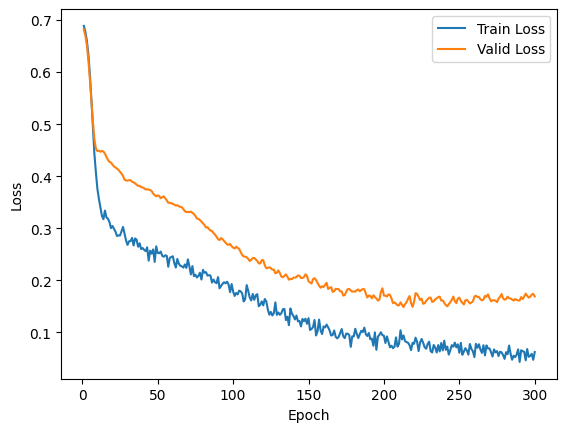

In [47]:
plt.plot(range(1, Ne+1), train_losses, label='Train Loss')
plt.plot(range(1, Ne+1), val_losses, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Validação

In [48]:
model.eval()
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs)
        predictions = (outputs >= 0.5).float()
        accuracy = accuracy_score(targets.cpu(), predictions.cpu())
        f1 = f1_score(targets.cpu(), predictions.cpu())
        cm = confusion_matrix(targets.cpu(), predictions.cpu())

print(f'Accuracy: {accuracy:.2f}')
print(f'F1 Score: {f1:.2f}')

Accuracy: 0.98
F1 Score: 0.98


In [41]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=0, ha='right')
  plt.ylabel('Rótulo verdadeiro')
  plt.xlabel('Rótulo previsto');

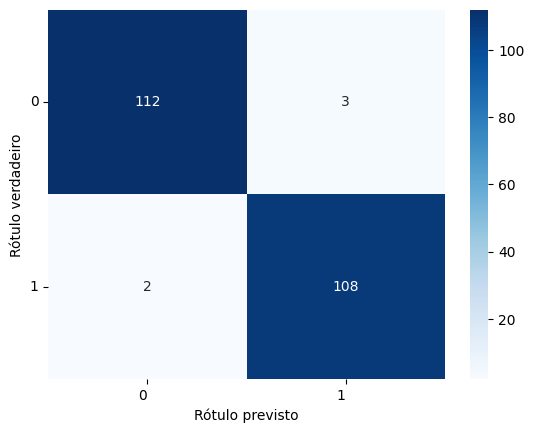

In [49]:
show_confusion_matrix(cm)

In [50]:
torch.save(model.state_dict(), "./model01.pt")

## Modelo de regressão logística

In [51]:
class LogisticRegression(nn.Module):
    def __init__(self, input_size):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        return self.sigmoid(self.linear(x))

In [52]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
reg_model = LogisticRegression(input_size=X_train.shape[1]).to(device)

optimizer = torch.optim.Adam(reg_model.parameters(), lr=eta) 
loss_function = nn.BCELoss()

### Treinamento

In [53]:
train_losses = []
val_losses = []
accuracies = []

for epoch in range(Ne):
    reg_model.train()
    train_loss = 0.0
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        outputs = reg_model(inputs)
        loss = loss_function(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    reg_model.eval()
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = reg_model(inputs)
            predictions = (outputs >= 0.5).float()
            cm_train = confusion_matrix(targets.cpu(), predictions.cpu())
            accuracy = accuracy_score(targets.cpu(), predictions.cpu())
            accuracies.append(accuracy)
        valid_loss = loss_function(outputs, targets)
        val_losses.append(valid_loss.item())
            
    if (epoch+1) % 10 == 0:
        print(f'Epoch {epoch+1}/{Ne}, Train Loss: {train_loss:.4f}, Validation Loss: {valid_loss:.4f}, Accuracy: {accuracy:.2f}')

Epoch 10/300, Train Loss: 0.5322, Validation Loss: 0.5654, Accuracy: 0.71
Epoch 20/300, Train Loss: 0.4646, Validation Loss: 0.5131, Accuracy: 0.77
Epoch 30/300, Train Loss: 0.4249, Validation Loss: 0.4832, Accuracy: 0.79
Epoch 40/300, Train Loss: 0.3993, Validation Loss: 0.4650, Accuracy: 0.79
Epoch 50/300, Train Loss: 0.3816, Validation Loss: 0.4536, Accuracy: 0.80
Epoch 60/300, Train Loss: 0.3690, Validation Loss: 0.4462, Accuracy: 0.80
Epoch 70/300, Train Loss: 0.3596, Validation Loss: 0.4415, Accuracy: 0.80
Epoch 80/300, Train Loss: 0.3524, Validation Loss: 0.4386, Accuracy: 0.80
Epoch 90/300, Train Loss: 0.3468, Validation Loss: 0.4369, Accuracy: 0.80
Epoch 100/300, Train Loss: 0.3425, Validation Loss: 0.4361, Accuracy: 0.80
Epoch 110/300, Train Loss: 0.3391, Validation Loss: 0.4358, Accuracy: 0.80
Epoch 120/300, Train Loss: 0.3363, Validation Loss: 0.4360, Accuracy: 0.80
Epoch 130/300, Train Loss: 0.3341, Validation Loss: 0.4364, Accuracy: 0.80
Epoch 140/300, Train Loss: 0.3323,

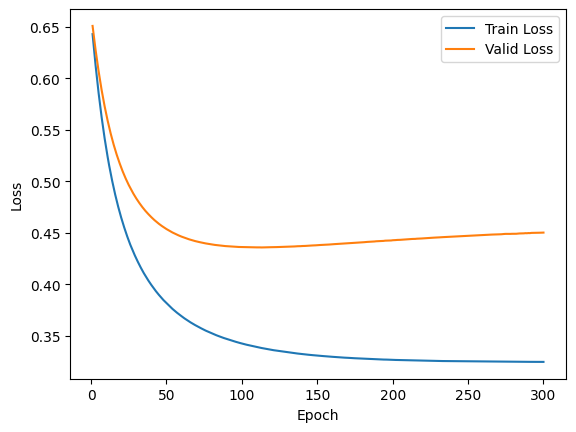

In [54]:
plt.plot(range(1, Ne+1), train_losses, label='Train Loss')
plt.plot(range(1, Ne+1), val_losses, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Validação

In [55]:
reg_model.eval()
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = reg_model(inputs)
        predictions = (outputs >= 0.5).float()
        accuracy = accuracy_score(targets.cpu(), predictions.cpu())
        f1 = f1_score(targets.cpu(), predictions.cpu())
        cm = confusion_matrix(targets.cpu(), predictions.cpu())

print(f'Accuracy: {accuracy:.2f}')
print(f'F1 Score: {f1:.2f}')

Accuracy: 0.80
F1 Score: 0.81


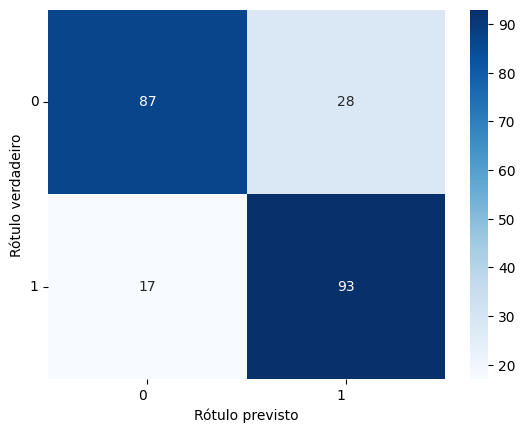

In [56]:
show_confusion_matrix(cm)

In [57]:
torch.save(model.state_dict(), "./model_logreg.pt")

## Conclusão

A comparação do modelo de MLP com 4 camadas com o modelo de regressão logística mostra que a rede MLP atingiu acurácia e F1 score superiores. Além disso, o treinamento de ambos os modelos mostrou como a perda da rede de MLP atinge valor menor do que no caso do treinamento da rede de regressão logística, embora a MLP precise de mais épocas para que o valor de perda se estabilize.